In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import quad
from scipy.misc import derivative
from data.parameters import XI_5, XI_6, XI_7, XI_8

# understanding the waiting time function

the probability of having to wait the owl is a Survival function (S(t)): Probability of event not occurring by time t (in hours)

In [2]:
def survival_function(hours):
    """
    Calculate the probability of having to wait (event did not occur yet).

    Parameters:
    hours (float): The number of hours to calculate the waiting probability for.
    Returns:
    float: The estimated probability of waiting for the given number of hours.
    """
    return XI_5 * np.exp(-XI_6 * np.sqrt(hours)) + XI_7 * np.exp(-XI_8 * np.cbrt(hours))



## probability that you need to wait between two and four hours to hear the owl

it is simply the difference between the two survival functions at 2 and 4 hours

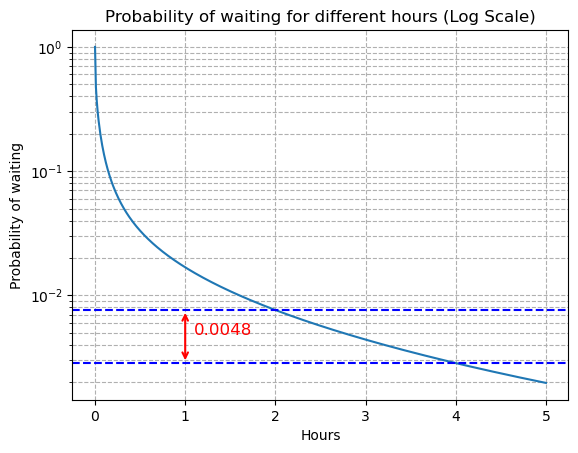

In [3]:
# Plot the probability of waiting for different hours using a log scale
# find the probabilities for 2 hours and 4 hours

hours = np.linspace(0, 5, 501)
proba = survival_function(hours)
plt.plot(hours, proba)
plt.xlabel('Hours')
plt.ylabel('Probability of waiting')
plt.yscale('log')
plt.title('Probability of waiting for different hours (Log Scale)')
# find the point a where time is 2 hours
# find the point b where time is 4 hours
index_2h = np.where(hours == 2)[0]
index_4h = np.where(hours == 4)[0]
proba_2h = proba[index_2h]
proba_4h = proba[index_4h]
# draw horizontal lines at a and b (not vertical lines)

plt.axhline(y=proba[index_2h], color='b', linestyle='--')
plt.axhline(y=proba[index_4h], color='b', linestyle='--')
# add log grid
plt.grid(True, which="both", ls="--")

# Draw a vertical arrow between the lines
plt.annotate(
    '', xy=(1.0, proba_4h), xytext=(1.0, proba_2h),
    arrowprops=dict(arrowstyle='<->', color='red', lw=1.5)
)

# Add the text showing the difference in probabilities
prob_difference = proba_2h - proba_4h
plt.text(1.1, (proba_2h + proba_4h) / 2, 
         f'{prob_difference[0]:.4f}', 
         color='red', fontsize=12, verticalalignment='center')


# save it to a file prob_waiting_2_4 in the folder figures
plt.savefig('figures/prob_waiting_2_4.pdf')

## compute the pdf

the pdf is the derivative of the survival function. scipy has a function to compute the pdf from the survival function

In [4]:
# Define a conversion function between hours and minutes
def hours_to_minutes(hours):
    return hours * 60

def minutes_to_hours(minutes):
    return minutes / 60

In [5]:
# Define the PDF (derivative of 1 - S(t))
def pdf(minutes):
    hours = minutes_to_hours(minutes)
    delta = 1e-6
    return -(survival_function(hours + delta) - survival_function(hours - delta)) / (2 * delta)


In [6]:
from scipy.stats import rv_continuous
# Create a custom probability distribution for the event occurrence time
class CustomDistribution(rv_continuous):
    """
    Custom probability distribution for the event occurrence time.
    units: minutes
    """
    
    def _pdf(self, t):
        return pdf(t)

    def _cdf(self, t):
        return 1 - survival_function(minutes_to_hours(t))

## represent statistics

In [7]:
# Instantiate the custom distribution
event_time_dist = CustomDistribution(a=0, b=np.inf, name="event_time_distribution")


In [8]:
mean_time_hours = event_time_dist.mean()
std_time_hours = event_time_dist.std()
var_time_hours = event_time_dist.var()
q1_hours = event_time_dist.ppf(0.25)
median_hours = event_time_dist.ppf(0.5)
q3_hours = event_time_dist.ppf(0.75)

In [22]:

# Print the results
print("Mean:", mean_time_hours)
print("variance:", var_time_hours)
print("Standard deviation:", std_time_hours)
print("Q1:", q1_hours)
print("Median:", median_hours)
print("Q3:", q3_hours)

Mean: 5.694444444481217
variance: 1166.8209875412615
Standard deviation: 34.158761504792025
Q1: 0.07024474192805888
Median: 0.508555897603456
Q3: 2.4670213860910293


In [23]:
# Convert statistics to minutes
mean_minutes = hours_to_minutes(mean_time_hours)
std_minutes = hours_to_minutes(std_time_hours)
q1_minutes = hours_to_minutes(q1_hours)
median_minutes = hours_to_minutes(median_hours)
q3_minutes = hours_to_minutes(q3_hours)


In [33]:
# Generate time points for visualization (in minutes)
time_points_minutes = np.linspace(3, 7*60,)  # From 1 minute to 7 hours

time_points_hours = minutes_to_hours(time_points_minutes)
pdf_values = [pdf(t) for t in time_points_minutes]

In [34]:
pdf_values[-1]

np.float64(0.0002931937040156693)

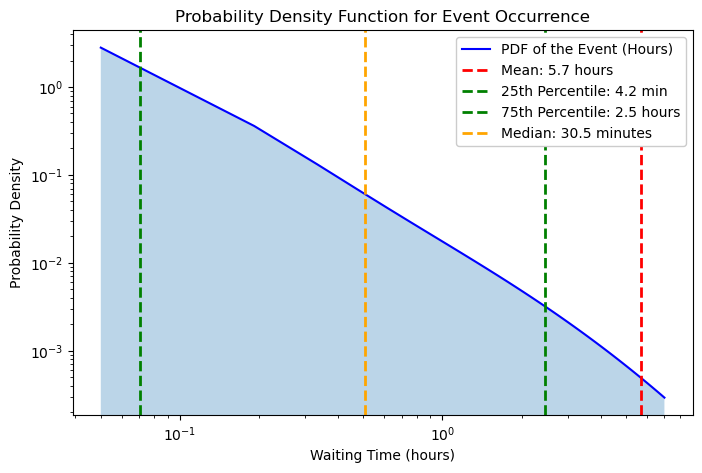

In [39]:
# Plot the PDF
plt.figure(figsize=(8, 5))
plt.plot(time_points_hours, pdf_values, label="PDF of the Event (Hours)", color="blue")
plt.xscale('log')
plt.yscale('log')
plt.fill_between(time_points_hours, pdf_values, alpha=0.3)

# Plot the mean, variance, and quartiles on the histogram
plt.axvline(mean_time_hours, color="red", linestyle="dashed", linewidth=2, label=f'Mean: {mean_time_hours:.1f} hours')
plt.axvline(q1_hours, color="green", linestyle="dashed", linewidth=2, label=f'25th Percentile: {q1_minutes:.1f} min')
plt.axvline(q3_hours, color="green", linestyle="dashed", linewidth=2, label=f'75th Percentile: {q3_hours:.1f} hours')
plt.axvline(median_hours, color="orange", linestyle="dashed", linewidth=2, label=f'Median: {median_minutes:.1f} minutes')

# Add labels and title
plt.xlabel("Waiting Time (hours)")
plt.ylabel("Probability Density")
plt.title("Probability Density Function for Event Occurrence")

# Display legend in the upper right corner with no transparency
plt.legend(loc="upper right", framealpha=1)

# save the plot to a file pdf_event_occurrence in the folder figures
plt.savefig('figures/pdf_event_occurrence.pdf')

##plot an histogram of some minutes

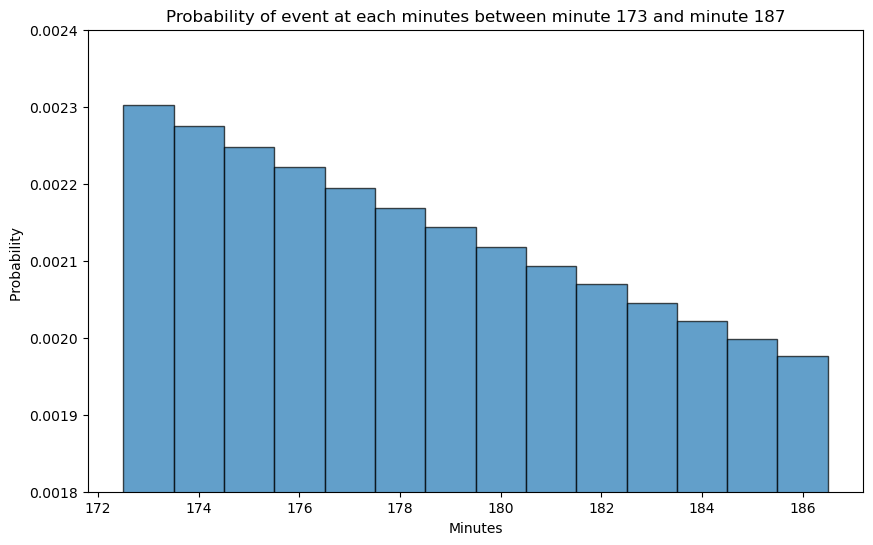

In [42]:
# Define the range of minutes (175 to 185)
minutes_range = np.arange(173, 187)

# Calculate the probability density for each minute
probabilities = [event_time_dist.pdf(minute) for minute in minutes_range]

# Plot the probability density function as an histogram
plt.figure(figsize=(10, 6))
plt.ylim(bottom=0.0018, top=0.0024)
plt.bar(minutes_range, probabilities, width=1, edgecolor='black', alpha=0.7)

#put title and labels
plt.title('Probability of event at each minutes between minute 173 and minute 187')
plt.xlabel('Minutes')
plt.ylabel('Probability ')
# save as pdf in folder figures
plt.savefig('figures/event_time_dist_hist.pdf')


